In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time
import random
from datetime import datetime
import cv2

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log
from custom_transforms import Cutout, Shadowcasting

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {"rbg": {"mean": mean[:3],
                                "std": std[:3]},
                        "depth": {"mean": mean[3],
                                  "std": std[3]},
                        "normal": {"mean": mean[4:],
                                   "std": std[4:]}}

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(**params.learning.JITTER_PARAMS),

    # Randomly adds a black patch to the image
    Cutout(0.5),
    
    # Randomly cast a shadow on the image
    Shadowcasting(0.5),

    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

transform_depth = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"]
        ),
])

transform_normal = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_test.csv",
    images_directory=params.learning.DATASET+"images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (13078 samples)
15.0 % of the data for validation (2803 samples)
15.0 % of the data for testing (2803 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model
model = ResNet18Velocity(**params.learning.NET_PARAMS).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS["nb_input_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32, 10])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [11]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(params.learning.DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None],
                              dtype=torch.float32,
                              device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy, train_regression_loss = train(model,
                                                              device,
                                                              train_loader,
                                                              optimizer,
                                                              criterion_classification,
                                                              criterion_regression,
                                                              bins_midpoints,
                                                              epoch)
    
    # Validation
    val_loss, val_accuracy, val_regression_loss = validate(model,
                                                           device,
                                                           val_loader,
                                                           criterion_classification,
                                                           criterion_regression,
                                                           bins_midpoints,
                                                           epoch) 
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  10.6591221899373
Validation accuracy:  11.915804495183732
Train regression loss:  1.444208661763767
Validation regression loss:  1.390514543110674


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  12.616608044043431
Validation accuracy:  13.556903317873706
Train regression loss:  1.422691082021718
Validation regression loss:  1.349449593235146


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  14.757608196972013
Validation accuracy:  14.448804851944345
Train regression loss:  1.3947353689478195
Validation regression loss:  1.282260574400425


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  15.055818932558495
Validation accuracy:  14.270424545130217
Train regression loss:  1.3379207115010119
Validation regression loss:  1.2252683117985725


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  15.575776112555436
Validation accuracy:  15.090973956475205
Train regression loss:  1.2933310444459938
Validation regression loss:  1.2028851458294825


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  15.866340419024315
Validation accuracy:  15.05529789511238
Train regression loss:  1.3047390788574964
Validation regression loss:  1.2442960623990407


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  15.62165468726105
Validation accuracy:  14.8055654655726
Train regression loss:  1.2994429157240759
Validation regression loss:  1.2247164357792248


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.439822602844472
Validation accuracy:  15.126650017838031
Train regression loss:  1.317302504932385
Validation regression loss:  1.261269523338838


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.43217617372687
Validation accuracy:  15.44773457010346
Train regression loss:  1.3191109274156518
Validation regression loss:  1.277565944601189


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.890961920782996
Validation accuracy:  15.661790938280413
Train regression loss:  1.3165922433065027
Validation regression loss:  1.2710652127861977


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.317479736962838
Validation accuracy:  15.840171245094542
Train regression loss:  1.307240001584032
Validation regression loss:  1.2476375610990957


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.531579752255695
Validation accuracy:  15.519086692829111
Train regression loss:  1.3215150223967498
Validation regression loss:  1.2688549255782908


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.9139012081358
Validation accuracy:  15.626114876917589
Train regression loss:  1.3095999583055453
Validation regression loss:  1.2762306346134706


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.615690472549318
Validation accuracy:  15.982875490545844
Train regression loss:  1.3173209476878998
Validation regression loss:  1.3064672974022953


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.669215476372536
Validation accuracy:  16.3396361041741
Train regression loss:  1.327764223869389
Validation regression loss:  1.285341662439433


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.173879798134273
Validation accuracy:  16.839100963253657
Train regression loss:  1.3048602436603136
Validation regression loss:  1.2857140573588284


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.449151246367947
Validation accuracy:  15.911523367820193
Train regression loss:  1.3160917423756606
Validation regression loss:  1.2867774319919674


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.770301269307232
Validation accuracy:  15.661790938280413
Train regression loss:  1.3269618759819815
Validation regression loss:  1.2050255730070851


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  16.806851200489373
Validation accuracy:  16.125579735997146
Train regression loss:  1.301128394883536
Validation regression loss:  1.2973535325039516


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.80088698577764
Validation accuracy:  15.483410631466286
Train regression loss:  1.2961930759378635
Validation regression loss:  1.2657883539795876


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.75500841107203
Validation accuracy:  15.840171245094542
Train regression loss:  1.3126736700097623
Validation regression loss:  1.2837651751258157


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.076158434011315
Validation accuracy:  16.553692472351052
Train regression loss:  1.2961082661064447
Validation regression loss:  1.3041965568607503


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.50267625019116
Validation accuracy:  17.409917945058865
Train regression loss:  1.2881242839806237
Validation regression loss:  1.3209730569611897


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.617372686955193
Validation accuracy:  16.196931858722795
Train regression loss:  1.326169226163757
Validation regression loss:  1.239569673484022


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.060865575776113
Validation accuracy:  16.66072065643953
Train regression loss:  1.289732742571889
Validation regression loss:  1.2862055769020861


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.823826273130447
Validation accuracy:  17.267213699607563
Train regression loss:  1.3025953701918167
Validation regression loss:  1.3081127296794544


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.846765560483256
Validation accuracy:  17.267213699607563
Train regression loss:  1.3072680137268198
Validation regression loss:  1.273000081154433


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  17.441504817250344
Validation accuracy:  16.98180520870496
Train regression loss:  1.3034092202454732
Validation regression loss:  1.2733575376597317


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.22908701636336
Validation accuracy:  17.267213699607563
Train regression loss:  1.2758482691711202
Validation regression loss:  1.346116726371375


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.366722740480196
Validation accuracy:  16.946129147342134
Train regression loss:  1.3065980464438647
Validation regression loss:  1.3030641370198943


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.12968343783453
Validation accuracy:  17.088833392793436
Train regression loss:  1.3013626959329712
Validation regression loss:  1.2188600179823963


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.573176326655453
Validation accuracy:  17.05315733143061
Train regression loss:  1.2882122154049302
Validation regression loss:  1.220708685165102


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.427894173421013
Validation accuracy:  16.3396361041741
Train regression loss:  1.3174141321176422
Validation regression loss:  1.2169748795303432


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.443187031656215
Validation accuracy:  17.909382804138424
Train regression loss:  1.288435925044174
Validation regression loss:  1.1883915784684094


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.512004893714636
Validation accuracy:  17.588298251872992
Train regression loss:  1.2882508792912173
Validation regression loss:  1.2704395407980138


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.955497782535556
Validation accuracy:  16.696396717802354
Train regression loss:  1.2985814327424197
Validation regression loss:  1.2813897308978168


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.64199418871387
Validation accuracy:  17.05315733143061
Train regression loss:  1.2862707683975947
Validation regression loss:  1.3071560046889565


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.59611561400826
Validation accuracy:  18.016410988226898
Train regression loss:  1.3197206270432413
Validation regression loss:  1.1709052615545013


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  18.7413977672427
Validation accuracy:  17.766678558687122
Train regression loss:  1.271871218325748
Validation regression loss:  1.3588538935238665


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.42192995870928
Validation accuracy:  17.302889760970388
Train regression loss:  1.277128543859589
Validation regression loss:  1.2615559419447726


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.44486924606209
Validation accuracy:  17.409917945058865
Train regression loss:  1.2978687837246285
Validation regression loss:  1.2703887129371816


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.161951368710813
Validation accuracy:  17.23153763824474
Train regression loss:  1.2843894769043678
Validation regression loss:  1.3887313462116502


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.20018351429882
Validation accuracy:  18.1591152336782
Train regression loss:  1.2942500404448847
Validation regression loss:  1.3728094392202117


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.643676403119745
Validation accuracy:  17.731002497324294
Train regression loss:  1.2812227065376665
Validation regression loss:  1.2806104645133018


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.33017280929806
Validation accuracy:  17.552622190510167
Train regression loss:  1.2903915833144433
Validation regression loss:  1.2975947281176394


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.506040679002904
Validation accuracy:  17.873706742775596
Train regression loss:  1.2889570366491023
Validation regression loss:  1.2279972982677547


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.246062089004436
Validation accuracy:  17.802354620049947
Train regression loss:  1.280226148282403
Validation regression loss:  1.467152327299118


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.544272824590916
Validation accuracy:  17.338565822333216
Train regression loss:  1.2819892820198553
Validation regression loss:  1.2247499823570251


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.391344242238876
Validation accuracy:  16.553692472351052
Train regression loss:  1.282723630698794
Validation regression loss:  1.263521933420138


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.727787123413368
Validation accuracy:  17.12450945415626
Train regression loss:  1.279464337382748
Validation regression loss:  1.2008510255678133


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.4907478207677
Validation accuracy:  17.909382804138424
Train regression loss:  1.2726343964889173
Validation regression loss:  1.193841239945455


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.865422847530205
Validation accuracy:  17.980734926864073
Train regression loss:  1.2878020337275013
Validation regression loss:  1.3207144181836734


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.987765713411836
Validation accuracy:  17.23153763824474
Train regression loss:  1.2581058801823548
Validation regression loss:  1.2576099160042675


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.865422847530205
Validation accuracy:  18.19479129504103
Train regression loss:  1.277370174968738
Validation regression loss:  1.240197479724884


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  20.14069429576388
Validation accuracy:  18.230467356403853
Train regression loss:  1.2665407801898592
Validation regression loss:  1.35004315728491


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.949533567823828
Validation accuracy:  17.267213699607563
Train regression loss:  1.2654160427289372
Validation regression loss:  1.2196698385206135


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.987765713411836
Validation accuracy:  17.338565822333216
Train regression loss:  1.2782203419575773
Validation regression loss:  1.230673524466428


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.842483560177396
Validation accuracy:  17.766678558687122
Train regression loss:  1.2709948558970594
Validation regression loss:  1.2825364660133014


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  20.393026456644748
Validation accuracy:  17.302889760970388
Train regression loss:  1.2550236499688445
Validation regression loss:  1.2650957452979954


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  20.11010857929347
Validation accuracy:  16.482340349625403
Train regression loss:  1.2628486625722684
Validation regression loss:  1.4249398823488841


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  20.47713717693837
Validation accuracy:  18.123439172315376
Train regression loss:  1.2696874956338504
Validation regression loss:  1.230338123034347


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  19.91894785135342
Validation accuracy:  18.016410988226898
Train regression loss:  1.2716987879905841
Validation regression loss:  1.2191121185367757


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  20.80593362899526
Validation accuracy:  17.94505886550125
Train regression loss:  1.236244274963668
Validation regression loss:  1.301839635453441


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  20.99709435693531
Validation accuracy:  18.373171601855155
Train regression loss:  1.261336451929181
Validation regression loss:  1.317809890617024


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  20.752408625172045
Validation accuracy:  17.94505886550125
Train regression loss:  1.2585717935142424
Validation regression loss:  1.2794977033680135


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  20.614772901055208
Validation accuracy:  17.44559400642169
Train regression loss:  1.2331458881752415
Validation regression loss:  1.267244273966009


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.020033644288116
Validation accuracy:  17.83803068141277
Train regression loss:  1.241517312223579
Validation regression loss:  1.4240853569724343


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.134730081052147
Validation accuracy:  17.588298251872992
Train regression loss:  1.2544001483684064
Validation regression loss:  1.3597992292859338


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.302951521639393
Validation accuracy:  17.62397431323582
Train regression loss:  1.2432235278972494
Validation regression loss:  1.421042176810178


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.708212264872305
Validation accuracy:  17.588298251872992
Train regression loss:  1.2426224799785754
Validation regression loss:  1.359904357655482


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.65468726104909
Validation accuracy:  17.802354620049947
Train regression loss:  1.2484297143217986
Validation regression loss:  1.3466638001528652


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.945251567517968
Validation accuracy:  18.65858009275776
Train regression loss:  1.2331330857824871
Validation regression loss:  1.4059320363131436


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.356476525462607
Validation accuracy:  17.409917945058865
Train regression loss:  1.240607372414512
Validation regression loss:  1.2992296516895294


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.792322985165928
Validation accuracy:  17.516946129147343
Train regression loss:  1.23541343008102
Validation regression loss:  1.4182460795749317


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  22.67166233369017
Validation accuracy:  17.195861576881914
Train regression loss:  1.2143700256178607
Validation regression loss:  1.3880419297651811


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.777030126930722
Validation accuracy:  17.62397431323582
Train regression loss:  1.2685854907140754
Validation regression loss:  1.3268246935172514


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  22.679308762807768
Validation accuracy:  17.338565822333216
Train regression loss:  1.2071831981972552
Validation regression loss:  1.2710150717334314


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  21.90701942192996
Validation accuracy:  17.481270067784518
Train regression loss:  1.2317203928905478
Validation regression loss:  1.2865663042122668


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  22.564612326043736
Validation accuracy:  17.44559400642169
Train regression loss:  1.224523269168322
Validation regression loss:  1.7041283994913101


  0%|          | 0/409 [00:00<?, ?batch/s]

  0%|          | 0/88 [00:00<?, ?batch/s]

Train accuracy:  23.33690166692155
Validation accuracy:  17.62397431323582
Train regression loss:  1.2181097266872238
Validation regression loss:  1.5096577575260943


### Visualization

Text(0.5, 0, 'Epoch')

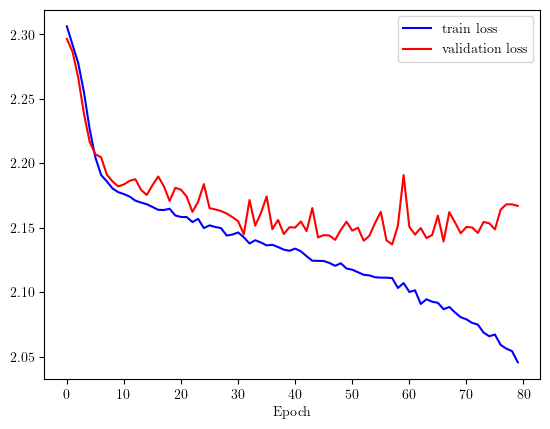

In [12]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

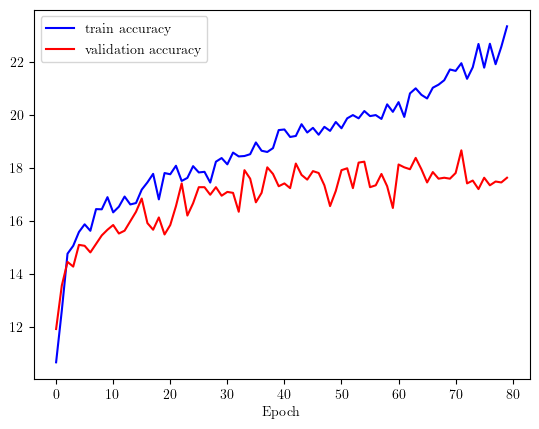

In [13]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

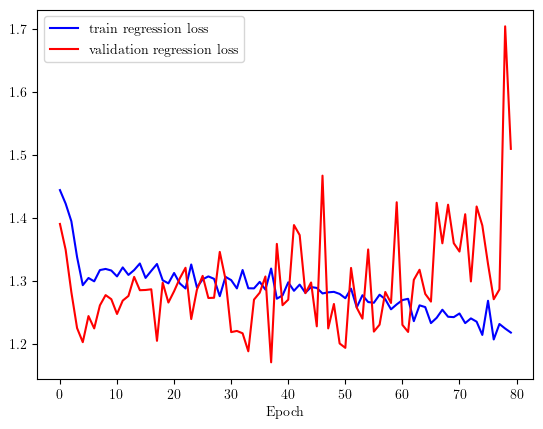

In [14]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Testing the model

In [15]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
_,\
test_accuracy,\
test_regression_loss,\
test_regression_losses,\
uncertainties = test(model,
                     device,
                     test_loader,
                     criterion_classification,
                     criterion_regression,
                     bins_midpoints,
                     uncertainty_function)

print("Test accuracy: ", test_accuracy)
print("Regression loss: ", test_regression_loss)

Test accuracy:  18.123439172315376
Regression loss:  1.6504188599911602


#### Comparing to the worst possible loss

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

dataset_dir = "/home/gabriel/PRE/datasets/dataset_multimodal_siamese_png_quantilebinning/traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)
costs = costs_df['traversal_cost'].to_numpy()
mean_dataset_value = costs_df['traversal_cost'].mean()

print(mean_dataset_value)


discretizer = KBinsDiscretizer(
            n_bins=10,
            encode="ordinal",
            strategy="quantile")
discretizer.fit(costs.reshape(-1, 1))
edges = discretizer.bin_edges_[0]
midpoints = (edges[:-1] + edges[1:])/2
print(midpoints)

mean_dataset_label = np.int32(discretizer.transform(mean_dataset_value.reshape(1, -1)))

mean_loss = 0.

# Add a progress bar
train_loader_pbar = tqdm(train_loader, unit="batch")

# Loop over the training batches
for images,\
    traversal_costs,\
    traversability_labels,\
    linear_velocities in train_loader_pbar:
    mean_tensor_label = torch.tensor(np.full(list(traversability_labels.shape), mean_dataset_label), dtype=torch.int64)
    mean_tensor_value = torch.tensor(np.full(list(traversal_costs.shape), mean_dataset_value), dtype=torch.float32)

    #loss = criterion_classification(mean_tensor_label, traversability_labels)
    #
    ## Accumulate batch loss to average over the epoch
    #train_loss += loss.item()
    #
    ## Get the number of correct predictions
    #train_correct += torch.sum(
    #    torch.argmax(mean_tensor_label, dim=1) == traversability_labels
    #    ).item()
    
    # Compute and accumulate the batch loss
    mean_loss += criterion_regression(
        mean_tensor_value,
        traversal_costs).item()

# Compute the losses and accuracies
mean_loss /= len(train_loader)
    
print(mean_loss)



3.140143006727703
[ 0.92315582  2.04635567  2.41349651  2.72123167  2.9897904   3.23630194
  3.47763621  3.75620341  4.15453574 10.525663  ]


100%|██████████| 409/409 [00:19<00:00, 20.81batch/s]

1.2309142617841222


#### Getting some stats about the dataset

In [17]:
from sklearn.preprocessing import KBinsDiscretizer

dataset_dir = "/home/gabriel/PRE/datasets/dataset_multimodal_siamese_png_quantilebinning/traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)

display(costs_df.groupby(['traversability_label']).count())

,image_id,traversal_cost,linear_velocity
traversability_label,,,
0,1869,1869,1869
1,1868,1868,1868
2,1868,1868,1868
3,1869,1869,1869
4,1868,1868,1868
5,1868,1868,1868
6,1869,1869,1869
7,1868,1868,1868
8,1867,1867,1867


## Save model parameters

In [18]:
# Save the model parameters
# torch.save(model.state_dict(), "multimodal_velocity.params")

## Assessing the relevance of the uncertainty

In [19]:
import uncertainty.functions
import uncertainty.evaluation

# Compute the test losses after successive removal of the samples
# with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty =\
    uncertainty.evaluation.uncertainty_relevance(
        model,
        device,
        criterion_classification,
        criterion_regression,
        bins_midpoints,
        uncertainty_function,
        test,
        test_set,
        test_regression_loss,
        test_regression_losses,
        uncertainties)

#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

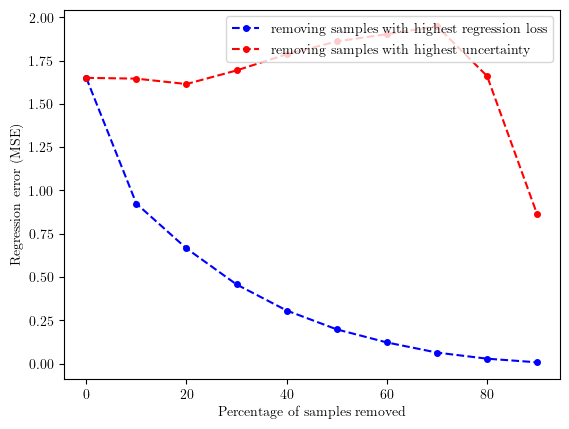

In [20]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")

## Generate a log directory

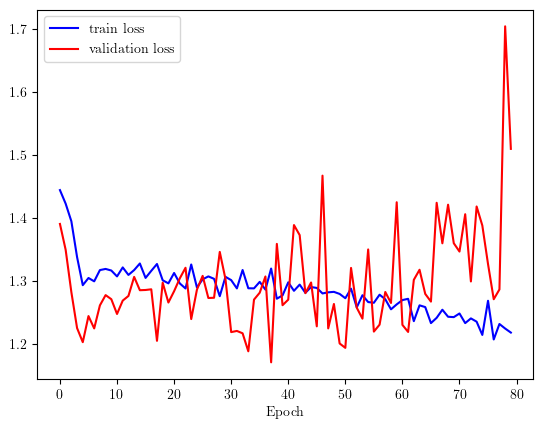

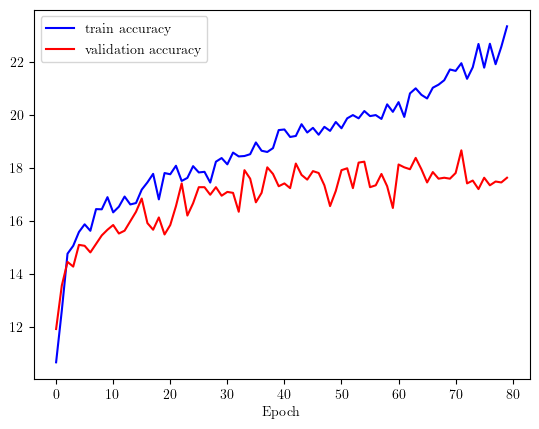

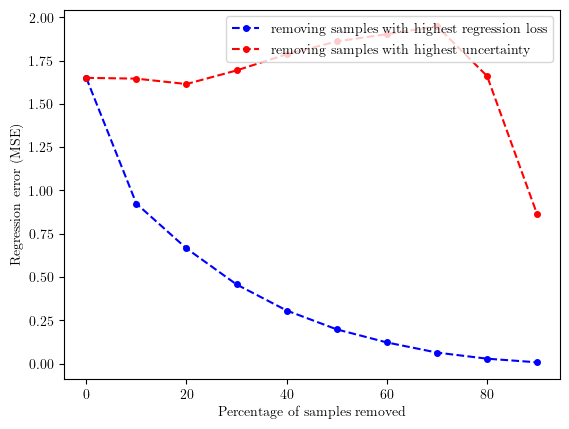

In [21]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = "logs/_" +\
                        params.learning.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(results_directory=results_directory,
             test_regression_loss=test_regression_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             regression_loss_values=regression_loss_values,
             accuracy_values=accuracy_values,
             test_losses_loss=test_losses_loss,
             test_losses_uncertainty=test_losses_uncertainty)

### Ensemble learning

#### Training the models

In [22]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

Training model 1/3


  0%|          | 0/409 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

#### Plotting the results

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")